# Cognitive Algorithms - Assignment 5 (30 points)
Cognitive Algorithms        
Summer term 2018      
Technische Universität Berlin     
Fachgebiet Maschinelles Lernen 

**Due on July 4, 2018 10am via ISIS  **
                    
After completing all tasks, run the whole notebook so that the content of each cell is properly displayed. Make sure that the code was ran and the entire output (e.g. figures) is printed. Print the notebook as a PDF file and again make sure that all lines are readable - use line breaks in the Python Code '\' if necessary. Points will be deducted, if code or content is not readable!                  
           
**Upload the PDF file that contains a copy of your notebook on ISIS.** 

# Part 1: Multiple Choice Questions (5 points)
---

**A)** Which statements about unsupervised learning are true?
- [ ] Its goal is to learn a mapping from input data to output data
- [x] Its goal is to find structure in the data
- [ ] It needs labels for training 
- [x] It does not need labels for training

**B)** Which of the following methods solve a supervised learning problem?
- [x] Linear Discriminant Analysis
- [x] Nearest Centroid Classifier
- [ ] Non-negative Matrix Factorization
- [ ] K-Means Clustering
- [x] Perceptron
- [x] Ordinary Least Squares
- [x] (Kernel) Ridge Regression
- [ ] Principal Component Analysis


**C)** Which statement about the Principal Components Analysis is **not** true?
- [ ] PCA finds the direction that maximizes the variance of the projected data
- [ ] The PCs are uncorrelated
- [x] The first $k$ PCs are the eigenvectors corresponding to the smallest $k$ eigenvalues

**D)** Cross-Validation can be used to ...
- [ ] ... estimate the generalization error
- [x] ... find optimal parameter values

**E)** Nested Cross-Validation can be used to ...
- [x] ... estimate the generalization error
- [x] ... find optimal parameter values

# Part 2: Programming (25 points)
---
### Task 1: Principal Component Analysis (16 points)
In this assignment, you will detect trends in text data and implement Principal Component Analysis (PCA). The text data consists of preprocessed news feeds gathered from http://beta.wunderfacts.com/ in October 2011, and you will be able to detect  a trend related to Steve Jobs death on 5th October 2011. 

The data consists of 26800 Bag-of-Words (BOW) features of news published every hour, i.e. the news are represented in a vector which contains the occurence of each word. Here we have many more dimensions (26800) than data points (645). This is why we will implement Linear Kernel PCA instead of standard PCA. 

Download the data set ```newsdata.npz```, if not done yet.  

In [3]:
import numpy as np
import pylab as pl
import scipy as sp
%matplotlib inline

In [47]:
def pca(X,ncomp=10):
    ''' Principal Component Analysis
    INPUT:  X       - DxN array of N data points with D features
            ncomp   - number of principal components to estimate 
    OUTPUT: W       - D x ncomp array of directions of maximal variance, 
                     sorted by their eigenvalues
            H       - ncomp x N array of projected data ''' 
    ncomp = min(np.hstack((X.shape, ncomp)))
    #center the data
    # ... 
    mean = np.mean(X, axis=1)
    X = X - mean[:,None]
    
    # compute linear kernel
    kernel = np.dot(X.T,X)
    
    # compute eigenvectors and sort them according to their eigenvalues
    eVals,eVecs = np.linalg.eig(kernel)
    max_eVec = eVecs[:,eVals.argsort()[::-1]]
    #print(max_eVec)
    
    # compute W and H 
    W=np.dot(X,max_eVec[:,:ncomp])
    H=np.dot(W.T,X)
    
    return W,H

def get_data(fname='newsdata_BOW.npz'):
    foo = np.load(fname)
    dates = foo['dates']
    BOW = np.array(foo['BOW_features'].tolist().todense())
    words = foo['words']
    return BOW,words,dates
    
def nmf(X,ncomp=10,its=100):
    '''Non-negative matrix factorization as in Lee and Seung http://dx.doi.org/10.1038/44565
    INPUT:  X       -  DxN array of N data points with D features
            ncomp   - number of factors to estimate
            its     - number of iterations
    OUTPUT: W       - D x ncomp array
            H       - ncomp x N array ''' 
    ncomp = min(np.hstack((X.shape, 10)))
    X = X + 1e-19
    # initialize randomly
    W = sp.random.rand(X.shape[0],ncomp)
    H = sp.random.rand(X.shape[1],ncomp).T
    # update for its iterations
    for it in sp.arange(its):
        H = H * (W.T.dot(X)/(W.T.dot(W.dot(H))))
        W = W * (X.dot(H.T)/(W.dot(H.dot(H.T))))
    return W,H
    
def plot_trends(ntopics=8,method=nmf,topwhat=10):
    #load data
    BOW,words,dates = get_data()
    topics,trends = method(BOW,ntopics)
    for itopic in range(ntopics):
        pl.figure(figsize=(8,6))
        pl.plot(trends[itopic,:].T)
        ranks = (-abs(topics[:,itopic])).argsort()
        thislabel = words[ranks[:topwhat]]
        pl.legend([thislabel])
        days = sp.arange(0,BOW.shape[-1],24*7)
        pl.xticks(days,dates[days],rotation=20)

def test_assignment6():
    ##Example 1
    X = sp.array([[0, 1], [0, 1]])
    W, H = pca(X, ncomp = 1)
    assert(sp.all(W / W[0] == [[1], [1]])) 
    print '2 datapoint test passed'
    
    ##Example 2
    #generate 2D data
    N =100
    cov = sp.array([[10, 4], [4, 5]])
    X = sp.random.multivariate_normal([0, -20], cov, N).T
    #do pca 
    W, H = pca(X)
    #plot result
    pl.figure()
    pc0 = 10*W[:,0] / np.linalg.norm(W[:,0])
    pc1 = 10*W[:,1] / np.linalg.norm(W[:,1])
    pl.plot([-pc0[0], pc0[0]], [-pc0[1]-20, pc0[1]-20], '-k', label='1st PC')
    pl.hold(True)
    pl.plot([-pc1[0], pc1[0]], [-pc1[1]-20, pc1[1]-20], '-.r', label='2nd PC')
    pl.plot(X[0,:], X[1,:], '+', color='k')
    pl.axis('equal')
    pl.legend(loc=1)

**A) (7 points)** Implement Linear Kernel Principal Component Analysis  by completing the function stub  ```pca```.  Given data $X \in \mathbb{R}^{D \times N}$, PCA finds a decomposition of the data in $k$ orthogonal principal components that maximize the variance in the data, 

$$X = W \cdot H$$ 

with $W \in \mathbb{R}^{D \times k}$ and   $H \in \mathbb{R}^{k \times N}$. The  Pseudocode is given below. The function  ```test_assignment6``` helps you to debug your code. It plots for a 2D data set the two principal components. 

```PCA( X, k ):```
1. ```# Require: data``` $x_1, \ldots, x_N \in \mathbb R^d$, $N\ll d$ ```, number of principal components``` $k$
1. ```# Center Data```
1. $\; \; \; X = X - 1/N\sum_ix_i$
1. ```# Compute Linear Kernel```
1. $\; \; \; K = X^{\top}X$
1. ```# Compute eigenvectors corresponding to the``` $k$ ```largest eigenvalues```
1. $\; \; \; \alpha = \text{eig}(K)$
1. $\; \; \;  W = X \alpha$
1. ```# Project data onto``` $W$
1. $\; \; \; H = W^\top X$
1. ```return W, H```

2 datapoint test passed


/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


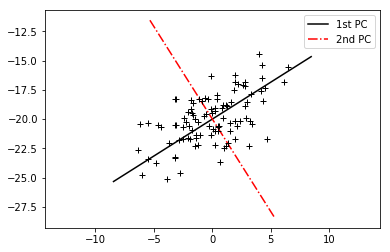

In [48]:
test_assignment6()

**B) (3 points)** What happens when you forget to center the data in ```pca```? Show the resulting plot for the 2D toydata example and explain the result. 

**[Your answer for B) here]**

In [ ]:
test_assignment6()

**C) (3 points)** Suppose we only have two data points, $ \begin{bmatrix}0 \\ 1 \end{bmatrix}$ and $ \begin{bmatrix}0 \\ 2 \end{bmatrix}$, $X = \begin{bmatrix} 0 & 0 \\ 1 & 2 \end{bmatrix}$. What would be the principal directions $W = [\mathbf w_1, \mathbf w_2]$? What will be the variance of the projected data onto each of the principal components $\mathbb V(\mathbf w_1^T X)$, $\mathbb V(\mathbf w_2^T X)$? What is $H$? 

*Hint:* You can obtain the result simply by visualizing the two data points and remembering PCA's objective. Or you can calculate the result using ```standard``` PCA. With Linear Kernel PCA, you will not be able to compute $\mathbf{w_2}$, because the corresponding eigenvalue is $0$. 

**[Your answer for C) here]**          
$
\mathbf{w}_1 = \\
\mathbf{w}_2 = \\
\mathbb V(\mathbf w_1^T X) = \\
\mathbb V(\mathbf w_2^T X) = \\
H = 
$

**D) (3 points)** Detect trends in the text data by calling the provided function ```plot_trends``` once for PCA and once for Non-Negative Matrix Factorization (NMF) (the code for NMF is provided as well). Which differences do you notice between the algorithms? Which method would you prefer for this task? Hand in the plot of the most prominent trend related to Steve Jobs death for each algorithm.  

**[Your answer for D) here]**

In [ ]:
plot_trends(method=pca)

In [ ]:
plot_trends(method=nmf)

### Task 2: K-Means Clustering (9 points)
In this exercise we want to implement the $K$-Means Clustering algorithm. It finds cluster centers $\mu_1 \ldots \mu_K$ such that the distance of the data points to their respective cluster center are minimized. This is done by re-iterating two steps:
1. Assign each data point $x_n$ to their closest cluster $\mu_k$ (for all $n = 1 \ldots N$)
1. Update each cluster center $\mu_k$ to the mean of the members in that cluster $k$ (for all $k = 1 \ldots K$)

Complete the function ```kmeans``` (see Task 2.A to 2.D for more detail). ```test_kmeans``` helps you to debug your code. It generates a simple 2D toy dataset. Your ```kmeans``` implementation should correctly identify the three clusters and should converge after only a few iterations (less than 10).

**A) (2 points)** Initialize the centroids. To do so calculate the mean of the whole data set and add some standard normal distributed noise to it, i.e. for all $k = 1 \ldots K$

$$ \mu_k = \bar{x} + \epsilon_k$$

where $\bar{x}, \epsilon_k \in \mathbb{R}^D$ and $\bar{x} = \frac{1}{N} \sum_{n=1}^{N} \mathbf{x_n}$ and $\epsilon_k \sim \mathcal{N}(\mathbf{0}, I)$ 

**B) (4 points)** For step 1 of the algorithm, we need the distance between each data point $x_n$ and each centroid $\mu_k$. Complete the function ```distmat``` that calculates a matrix $Dist \in \mathbb{R}^{N,K}$ such that 

$$Dist_{n,k} = || x_n - \mu_k ||_2^2 $$

We can calculate the matrix $Dist$ without the use of for-loops by using following formula:

$$Dist = A - 2 B + C  $$

where $A_{n,k} = x_n^T x_n \; \; , \; \; B_{n,k} = x_n^T \mu_k \;$ and $\; C_{n,k} = \mu_k^T \mu_k$

**C) (1 point)** Assign each data point to its closest centroid. To do so, construct a matrix $Closest \in \mathbb{R}^{N,K}$ such that 

$$Closest_{n,k} = \begin{cases} 1 & \; \; \tt{if} \; \; \mu_k \text{ is the closest centroid to } x_k \\ 0 & \; \; \text{otherwise} \end{cases}$$

i.e. each row of $Closest$ holds only one non-zero element.

**D) (2 points)** Update each cluster center to the mean of the members in that cluster, i.e. for all $k = 1 \ldots K$ 

$$ \mu_k = \frac{1}{|{\mathcal{X_k}}|} \sum_{x \in \mathcal{X_k}} x  $$ 

$$ \mathcal{X_k} = \{ x_n \in X \; | \text{ the closest centroid to } x_n \text{ is } \mu_k \} $$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def kmeans(X, K, max_iter=50, eta=0.05):
    """ k-Means Clustering
    INPUT:  X            - DxN array of N data points with D features
            K            - number of clusters
            max_iter     - maximum number of iterations
            eta          - small threshold for convergence criterion
    OUTPUT: centroids    - DxK array of K centroids with D features
            closest      - NxK array that indicates for each of the N data points
                           in X the closest centroid after convergence.
                           Each row in closest only holds one non-zero entry. 
                           closest[n,k] == 1 <=> 
                           centroids[:,k] is closest to data point X[:,n]
    """
    D,N = np.shape(X)
    dist = np.zeros([N,K])
    closest = np.zeros([N,K])
    # initialize the centroids (close to the mean of X)
    # ... your code here ...
    
    cur_iter = 0
    while cur_iter < max_iter:
        plot_cluster(X, centroids, closest)
        cur_iter += 1
        old_centroids = centroids.copy()
        # calculate the distance between each data point and each centroid
        dist = distmat(X,centroids)
        # get for each data point in X it's closest centroid
        # ... your code here ...
        
        # update the estimation of the centroids
        # ... your code here ...
        
        if np.linalg.norm(old_centroids - centroids) < eta:
            print 'Converged after ' + str(cur_iter) + ' iterations.'
            break;
    return centroids, closest

def distmat(X, Y):
    """ Distance Matrix
    INPUT:      X           - DxN array of N data points with D features
                Y           - DxM array of M data points with D features
    OUTPUT:     distmat     - NxM array s.t. D[n,m] = || x_n - y_m ||^2
    Hint: np.tile might be helpful
    """
    D_x,N = np.shape(X)
    D_y,M = np.shape(Y)
    assert D_x == D_y
    # calculate the distance matrix
    # ... your code here ...
    
    
def test_kmeans():
    #generate 2D data
    N =500
    cov = np.array([[1, 0], [0, 0.5]])
    # generate for each of the three clusters N data points
    x1 = np.random.multivariate_normal([-2, 2], cov, N) 
    x2 = np.random.multivariate_normal([2, 2], cov, N) 
    x3 = np.random.multivariate_normal([-2, -2], cov, N)
    X = np.vstack((x1, x2, x3)).transpose()
    
    # run kmeans and plot the result
    centroids, closest = kmeans(X, 3)
    plot_cluster(X, centroids, closest)

    
def plot_cluster(X, centroids, closest):
    K = np.shape(centroids)[1]
    plt.figure()
    plt.scatter(X[0], X[1])
    if (closest != np.zeros(np.shape(closest))).any():
        for k in xrange(K):
            # get for each centroid the assigned data points
            Xk = X[:, closest[:,k]]
            # plot each cluster in a different color
            plt.scatter(Xk[0], Xk[1])
    # plot each centroid (should be center of cloud)
    plt.scatter(centroids[0], centroids[1])


In [ ]:
test_kmeans()